### 1. Create separte directory for pass and fail images on the accout of whether it is referencable or not
### 2. Train models to classify image wheter is referencable

In [1]:
# Due to the size of image file, utilized google shared folder
# All collected product photos in a image_classification folder. 
!gdown 1WNV5Rv34xnQTMv1kj1awyQErf56cH3q-
!unzip -qq "/content/image_classification.zip"

Downloading...
From: https://drive.google.com/uc?id=1WNV5Rv34xnQTMv1kj1awyQErf56cH3q-
To: /content/image_classification.zip
100% 4.12G/4.12G [00:48<00:00, 84.8MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from keras.api._v2.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix
import cv2
import optuna
import time
import PIL
from tensorflow.keras.layers import Dense, Dropout

In [82]:
test_path = "/content/drive/MyDrive/DeepLearning/Project/test/"
pass_path = "/content/drive/MyDrive/DeepLearning/Project/model_pass/"
fail_path = "/content/drive/MyDrive/DeepLearning/Project/model_fail/"
image_list = os.listdir("/content/image_classification/fail")

test_list = os.listdir(test_path)
for i,img in enumerate(test_list):
  image = cv2.imread(f"/content/drive/MyDrive/DeepLearning/Project/test/{img}")
  imageHeight, imageWidth, _ = image.shape

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # change BGR to RGB 
  image_resized = cv2.resize(image, (150,200), interpolation=cv2.INTER_AREA)

  test = image_resized/255.0
  test = test.reshape(-1,200,150,3)
  test = feature_model.predict(test)
  test = model.predict(test)
  if test[0][0] > test[0][1]:
    shutil.copy(test_path + str(test_list[i]),
              fail_path)
    print(str(test_list[i]) + " ============> fail")
  else:
    shutil.copy(test_path + str(test_list[i]),
              pass_path)
    print(str(test_list[i]) + " ============> pass")
shutil.rmtree (test_path)

In [85]:
batch_size = 32
image_height = 200
image_width = 150

train_data_sub_folder = "/content/image_classification/"

def feature_model():
  url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"
  feature_model = tf.keras.Sequential(
      [
          hub.KerasLayer(url, output_shape=(1536,),
                        trainable=False)
      ]
  )
  feature_model.build( [ None, 299,299,3])
  return feature_model

feature_model = feature_model()

train_datagen = ImageDataGenerator(
    rescale = 1./255.,
	validation_split = 0.2
)
valid_datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2
)
train_generator = train_datagen.flow_from_directory(
    directory = train_data_sub_folder,
    subset = "training",
    batch_size = 128,
    seed = 42, shuffle = True,
    class_mode = "categorical",
    target_size = (image_height, image_width)
)
valid_generator = valid_datagen.flow_from_directory(
    directory = train_data_sub_folder,
    subset = "validation",
    batch_size = 32,
    seed = 42, shuffle = True,
    class_mode = "categorical",
    target_size = (image_height, image_width)
)

Found 8191 images belonging to 2 classes.
Found 2047 images belonging to 2 classes.


In [86]:
# get feautres of target 
batch_step = int(8191*1) // 128
train_features = []
train_y = []

for idx in range(batch_step):
    if idx % 200 == 0:
        print(idx)
    x,y = train_generator.next()
    train_y.extend(y)
    features = feature_model.predict(x)
    train_features.extend(features)
train_features = np.array(train_features)
train_y = np.array(train_y)
print(train_features.shape)

batch_step = int(2047*1) // 32
valid_features = []
valid_y = []

for idx in range(batch_step):
    if idx % 200 == 0:
        print(idx)
    x,y = valid_generator.next()
    valid_y.extend(y)
    features = feature_model.predict(x)
    valid_features.extend(features)
valid_features = np.array(valid_features)
valid_y = np.array(valid_y)
print(valid_features.shape)

0
4/4 [==============================] - 0s 112ms/step
(8064, 1536)
0
1/1 [==============================] - 0s 47ms/step
(2016, 1536)


In [7]:
!gdown 1WgyfZxm_TR3xDH3J8EO1Z2XkU_d4MsY7
!unzip -qq "/content/test.zip"

Downloading...
From: https://drive.google.com/uc?id=1WgyfZxm_TR3xDH3J8EO1Z2XkU_d4MsY7
To: /content/test.zip
100% 626M/626M [00:09<00:00, 68.9MB/s]


In [ ]:
# save extracted feature 
np.save("train_features.npy", train_features)
np.save("train_y.npy", train_y)
np.save("valid_features.npy", valid_features)
np.save("valid_y.npy", valid_y)

In [94]:
# DNN model to 
def dnn_model(train_features,train_y,valid_features,valid_y):
  # parameters = {'dnn_dropout_rate1': 0.18561604284653604, 'dnn_num_node1': 401, 'dnn_dropout_rate2': 0.1828819991412686, 'dnn_num_node2': 146, 'dnn_dropout_rate3': 0.43295663182166455, 'dnn_num_node3': 97, 'dnn_dropout_rate4': 0.14976317263034797, 'dnn_num_node4': 50}
  parameters = {'dnn_dropout_rate1': 0.1, 'dnn_num_node1': 256, 'dnn_dropout_rate2': 0.1, 'dnn_num_node2': 128, 'dnn_dropout_rate3': 0.1, 'dnn_num_node3': 64, 'dnn_dropout_rate4': 0.1, 'dnn_num_node4': 32}

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(input_shape = (1536,),
                            units = 512,
                            activation = "relu",
                            ),
      tf.keras.layers.Dense(units = parameters['dnn_num_node1'],activation = "relu"),
      tf.keras.layers.Dropout(rate = parameters['dnn_dropout_rate1']),
      tf.keras.layers.Dense(units = parameters['dnn_num_node2'],activation = "relu"),
      tf.keras.layers.Dropout(rate =  parameters['dnn_dropout_rate2']),
      tf.keras.layers.Dense(units = parameters['dnn_num_node3'],activation = "relu"),
      tf.keras.layers.Dropout(rate = parameters['dnn_dropout_rate3']),
      tf.keras.layers.Dense(units = parameters['dnn_num_node4'],activation = "relu"),
      tf.keras.layers.Dropout(rate = parameters['dnn_dropout_rate4']),
      tf.keras.layers.Dense(units = 16, activation = "relu"),
      tf.keras.layers.Dense(units = 2, activation = "softmax")
  ])
  model.compile(optimizer = Adam(),
                loss = "categorical_crossentropy",
                metrics = tf.keras.metrics.Precision())

  history = model.fit(train_features,train_y,
                      validation_data = (valid_features,valid_y),
                      epochs = 20, batch_size = 128)
  return model,history
model = 0
model,history = dnn_model(train_features,train_y,valid_features,valid_y)
# model.save('model.5h')

Epoch 1/20
63/63 [==============================] - 3s 10ms/step - loss: 0.4724 - precision_5: 0.7992 - val_loss: 0.3503 - val_precision_5: 0.8373
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3669 - precision_5: 0.8409 - val_loss: 0.3313 - val_precision_5: 0.8596
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 0.3355 - precision_5: 0.8590 - val_loss: 0.3193 - val_precision_5: 0.8666
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 0.3129 - precision_5: 0.8695 - val_loss: 0.3279 - val_precision_5: 0.8661
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 0.2959 - precision_5: 0.8748 - val_loss: 0.3299 - val_precision_5: 0.8403
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 0.2929 - precision_5: 0.8755 - val_loss: 0.2828 - val_precision_5: 0.8755
Epoch 7/20
63/63 [==============================] - 0s 8ms/step - loss: 0.2756 - precision_5: 0.8888 - val_loss: 0.3251 - v

In [16]:
folder_path = '/content/image_classification/.ipynb_checkpoints'  # path of .ipynb_checkpoints folder

# if the folder exsits delete 
if os.path.exists(folder_path):
    !rm -rf $folder_path
    print(f"{folder_path} 폴더가 삭제되었습니다.")
else:
    print(f"{folder_path} 폴더가 존재하지 않습니다.")

/content/image_classification/.ipynb_checkpoints 폴더가 삭제되었습니다.


In [55]:
# checking history of val_loss
history.history["val_loss"]

[0.3114674687385559,
 0.2717956602573395,
 0.2593478858470917,
 0.2726093828678131,
 0.25481510162353516,
 0.22784069180488586,
 0.25206300616264343,
 0.2612793743610382,
 0.23875579237937927,
 0.2614341378211975,
 0.32959309220314026,
 0.3447156250476837,
 0.43172720074653625,
 0.3500940203666687,
 0.3697988986968994,
 0.4561305642127991,
 0.5804198980331421,
 0.5681459903717041,
 0.5174270868301392,
 0.6036501526832581]

In [95]:
# Pass/fail folder
pass_dir = os.path.join(os.getcwd(), "/content/test/pass")
fail_dir = os.path.join(os.getcwd(), "/content/test/fail")

# Read images in Pass/fail folder
pass_images = []
fail_images = []
pass_list = os.listdir(pass_dir)
fail_list = os.listdir(fail_dir)

for img_file in pass_list[:100]:
  print(img_file)
  image = cv2.imread(os.path.join(pass_dir, img_file))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image_resized = cv2.resize(image, (150,200), interpolation=cv2.INTER_AREA)

  test = image_resized/255.0
  test = test.reshape(-1,200,150,3)
  test = feature_model.predict(test)
  test = model.predict(test)
  if test[0][0] > test[0][1]:
    img = 0
  else:
    img = 1
  pass_images.append(img)

for img_file in fail_list[:100]:
  image = cv2.imread(os.path.join(fail_dir, img_file))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
  image_resized = cv2.resize(image, (150,200), interpolation=cv2.INTER_AREA)

  test = image_resized/255.0
  test = test.reshape(-1,200,150,3)
  test = feature_model.predict(test)
  test = model.predict(test)
  if test[0][0] > test[0][1]:
    img = 0
  else:
    img = 1
  fail_images.append(img)

# Save images from Pass/fail folder to test_x and test_y folder 
y_pred = pass_images + fail_images
y_test = [1] * len(pass_images) + [0] * len(fail_images)

1142535_34067625_0.jpg
1/1 [==============================] - 0s 148ms/step
2903645_36455327_0.jpg
1/1 [==============================] - 0s 33ms/step
2723213_33775387_0.jpg
1/1 [==============================] - 0s 19ms/step
2723218_33946383_0.jpg
1/1 [==============================] - 0s 24ms/step
1551840_27146583_0.jpg
1/1 [==============================] - 0s 19ms/step
1551840_25571248_0.jpg
1/1 [==============================] - 0s 28ms/step
2734792_34820926_0.jpg
1/1 [==============================] - 0s 20ms/step
2844453_37332512_0.jpg
1/1 [==============================] - 0s 20ms/step
2910414_36557555_0.jpg
1/1 [==============================] - 0s 18ms/step
1551839_28857547_0.jpg
1/1 [==============================] - 0s 17ms/step
2789771_33800167_0.jpg
1/1 [==============================] - 0s 18ms/step
1613078_27452878_0.jpg
1/1 [==============================] - 0s 20ms/step
1738189_25248954_0.jpg
1/1 [==============================] - 0s 19ms/step
1337094_25745491_0.jpg
1

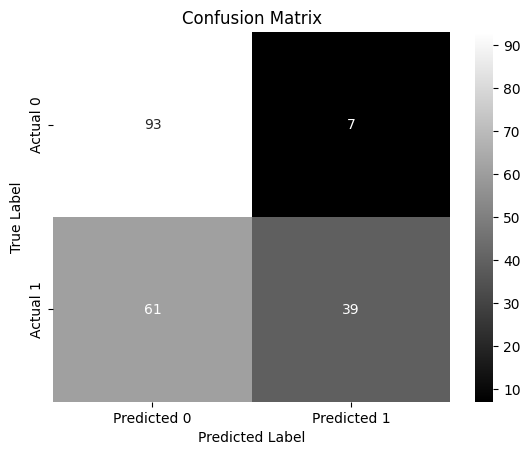

In [96]:
# visualize the performance of a classification model 
cm = confusion_matrix(y_test, y_pred) # Calculate the confusion matrix
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']) # Convert the confusion matrix into a DataFrame
# seaborn을 사용하여 히트맵으로 표현
sns.heatmap(cm_df, annot=True, fmt='d', cmap='gray')
# 플롯 설정
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

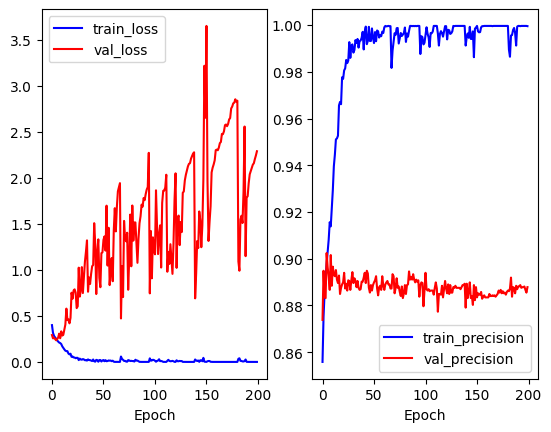

In [66]:
# check the training results
plt.subplot(1,2,1) # loss
plt.plot(history.history["loss"], "b-", label="train_loss")
plt.plot(history.history["val_loss"], "r-", label="val_loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2) # metrics : accuracy
plt.plot(history.history["precision_1"], "black", label="train_precision")
plt.plot(history.history["val_precision_1"], "r-", label="val_precision")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
!zip -r /content/image_classification_model.zip /content/image_classification_model

updating: content/image_classification_model/ (stored 0%)
  adding: content/image_classification_model/my_model.weights.index (deflated 63%)
  adding: content/image_classification_model/checkpoint (deflated 42%)
  adding: content/image_classification_model/my_model.weights.data-00000-of-00001 (deflated 30%)


In [ ]:
# Layer수 기반으로 Tunning
def create_model(dnn_dropout_rates, dnn_num_nodes, num_dl_layers):
    model = tf.keras.Sequential()
    model.add(Dense(input_shape=(1536,), units=512, activation="relu"))

    for i in range(num_dl_layers):
        model.add(Dense(units=dnn_num_nodes[i], activation="relu"))
        model.add(Dropout(rate=dnn_dropout_rates[i]))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(rate=dnn_dropout_rates[-1]))
    model.add(Dense(units=2, activation="softmax"))
    return model

def object_res(trial):
    tf.keras.backend.clear_session()

    num_dl_layers = trial.suggest_int("num_dl_layers", 2, 5)
    optimizers = trial.suggest_float("optimizers", 0.001, 0.1)

    dnn_num_nodes = []
    dnn_dropout_rates = []

    for i in range(num_dl_layers):
        dnn_num_node = trial.suggest_int(f"dnn{i+1}_num_node", 2**(8-i), 2**(9-i))
        dnn_dropout_rate = trial.suggest_float(f"dnn{i+1}_dropout_rate", 0.1, 0.5)
        dnn_num_nodes.append(dnn_num_node)
        dnn_dropout_rates.append(dnn_dropout_rate)

    model = create_model(dnn_dropout_rates, dnn_num_nodes, num_dl_layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(optimizers), loss="categorical_crossentropy", metrics=tf.keras.metrics.Precision())

    history = model.fit(train_features, train_y, validation_data=(valid_features, valid_y), epochs=20, batch_size=128)

    score = history.history["val_precision"][-1]

    return score


study = optuna.create_study(direction="maximize")
study.optimize(object_res, n_trials=100)

In [ ]:
# Layer 수 고정한 뒤 Node, Dropout Rate 조절
def create_model(dnn_dropout_rate1, dnn_num_node1,dnn_dropout_rate2, dnn_num_node2,dnn_dropout_rate3, dnn_num_node3,dnn_dropout_rate4, dnn_num_node4,optimizers):
    model = tf.keras.Sequential()
    model.add(Dense(input_shape=(1536,), units=512, activation="relu"))

    model.add(Dense(units=dnn_num_node1, activation="relu"))
    model.add(Dropout(rate=dnn_dropout_rate1))
    model.add(Dense(units=dnn_num_node2, activation="relu"))
    model.add(Dropout(rate=dnn_dropout_rate2))
    model.add(Dense(units=dnn_num_node3, activation="relu"))
    model.add(Dropout(rate=dnn_dropout_rate3))
    model.add(Dense(units=dnn_num_node4, activation="relu"))
    model.add(Dropout(rate=dnn_dropout_rate4))
    model.add(Dense(units=16, activation="relu"))
    model.add(Dense(units=2, activation="softmax"))
    return model

def object_res(trial):
    tf.keras.backend.clear_session()

    dnn_dropout_rate1 = trial.suggest_float("dnn_dropout_rate1", 0.1, 0.3)
    dnn_num_node1 = trial.suggest_int("dnn_num_node1", 200,300)
    dnn_dropout_rate2 = trial.suggest_float("dnn_dropout_rate2", 0.1, 0.3)
    dnn_num_node2 = trial.suggest_int("dnn_num_node2", 100,150)
    dnn_dropout_rate3 = trial.suggest_float("dnn_dropout_rate3", 0.1, 0.3)
    dnn_num_node3 = trial.suggest_int("dnn_num_node3", 50,80)
    dnn_dropout_rate4 = trial.suggest_float("dnn_dropout_rate4", 0.1, 0.3)
    dnn_num_node4 = trial.suggest_int("dnn_num_node4", 20,40)
    optimizers = trial.suggest_float("optimizer",0.0001,0.1)

    model = create_model(dnn_dropout_rate1, dnn_num_node1,dnn_dropout_rate2, dnn_num_node2,dnn_dropout_rate3, dnn_num_node3,dnn_dropout_rate4, dnn_num_node4, optimizers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = optimizers),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(train_features, train_y,
                        validation_data=(valid_features, valid_y),
                        epochs=20, batch_size=64)

    score = history.history["val_loss"][-1]
    return score

In [ ]:
study_my_res = optuna.create_study(direction = "maximize")
study_my_res.optimize(object_res,n_trials= 100)

In [ ]:
def create_model(dnn_dropout_rates, dnn_num_nodes, num_dl_layers):
    model = tf.keras.Sequential()
    model.add(Dense(input_shape=(1536,), units=512, activation="relu"))

    for i in range(num_dl_layers):
        model.add(Dense(units=dnn_num_nodes[i], activation="relu"))
        model.add(Dropout(rate=dnn_dropout_rates[i]))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(rate=dnn_dropout_rates[-1]))
    model.add(Dense(units=2, activation="softmax"))
    return model

def object_res(trial):
    tf.keras.backend.clear_session()

    num_dl_layers = trial.suggest_int("num_dl_layers", 3, 5)
    optimizers = trial.suggest_float("optimizers", 0.001, 0.1)

    dnn_num_nodes = []
    dnn_dropout_rates = []

    for i in range(num_dl_layers):
        dnn_num_node = trial.suggest_int(f"dnn{i+1}_num_node", 2**(8-i), 2**(9-i))
        dnn_dropout_rate = trial.suggest_float(f"dnn{i+1}_dropout_rate", 0.1, 0.5)
        dnn_num_nodes.append(dnn_num_node)
        dnn_dropout_rates.append(dnn_dropout_rate)

    model = create_model(dnn_dropout_rates, dnn_num_nodes, num_dl_layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(optimizers), loss="categorical_crossentropy", metrics=[tf.keras.metrics.Precision()])

    history = model.fit(train_features, train_y, validation_data=(valid_features, valid_y), epochs=20, batch_size=128)

    score = history.history["val_precision"][-1]

    return score


study = optuna.create_study(direction="maximize")
study.optimize(object_res, n_trials=100)

In [ ]:
# Model to check referencable image 
def checking_pass_fail(img_path):
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image_resized = cv2.resize(image, (150,200), interpolation=cv2.INTER_AREA)

  test = image_resized/255.0
  test = test.reshape(-1,200,150,3)
  test = feature_model.predict(test)
  test = model.predict(test)
  if test[0][0] > test[0][1]:
    print(str(test_list[i]) + " ============> fail")
    pf = 0
  else:
    print(str(test_list[i]) + " ============> pass")
    pf = 1
  return pf